# Genome Mining Notebook
### Nathan Alam 7/7/2020

Run through the steps after installing the pre-requisite MEME software

In [8]:
import os
import time
import json
import shutil
import sys
import yaml

import re
import traceback
import sys
import math
import pandas as pd
import sqlite3
import Bio
import time
from pathlib import Path
from Bio.Seq import Seq, reverse_complement, translate
from Bio.Alphabet import IUPAC
import matplotlib.pyplot as plt

## Configuration

Here are the parameters that you should edit for each run. The **runName** will be the name of the run, the **pattern** is the pattern to search lasso peptides against, the **cutoffRank** is the minimum required rank to run, the **genomeDir** is the directory where the FASTA and FNA files to be mined are stored, the **database** is where you would like the database to be written to, and **outputLogs** is where the output should be written to.

**models** is a list of models to generate motifs for and search with.

**memeDir** is the directory where the meme suite was installed on this computer, and **localMotifDir** is some empty or nonexistent directory that this program can use as scratch space.

In [2]:
config = yaml.load('''
# Setup parameters for a genome mining run

## Parameters for each run
runName: "nameOfRun"
pattern: 'M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*'
cutoffRank: 0
genomeDir: "/home/blucheez/Projects/lassomining/storage/genomes/"
database: "/home/blucheez/Projects/lassomining/storage/output/matches.db"
outputLogs: "/home/blucheez/Projects/lassomining/storage/output/runs/"
models:
  - location: "/home/blucheez/Projects/lassomining/storage/models/b.faa"
    numOfMotifs: 3
    maxWidth: 25
  - location: "/home/blucheez/Projects/lassomining/storage/models/c.faa"
    numOfMotifs: 4
    maxWidth: 25
  
## Parameters you should not have to change
memeDir: "/home/blucheez/meme"
localMotifDir: "/home/blucheez/Projects/lassomining/storage/scratch/"
''')

Below is a lot of the logic behind the mining, but just provides a series of functions to be used in the following code block

In [3]:
# Mining specific functions
'''
Define a function that takes as input the relative path of a FASTA formatted text file, return 
an object that contains a list of sequence objects. Each sequence object has a description field 
["description"] and a sequence field ["sequence"].

From http://www.csbio.sjtu.edu.cn/bioinf/virus-multi/example.htm, specification of a FASTA 
formatted file:
- The first line of each query protein input format must begin with a greater-than (">") symbol 
  in the first column. The word following the ">" symbol is the identifier and description of the 
  sequence, but both are optional.
- The sequence (in single-character code) begins in a different line and ends if another line 
  starting with a ">" appears, which indicates the start of another query protein.
'''
def readFASTA(name, cleanspace = 0):
    descriptions = []
    sequences = []
    sequenceList = []
    tempSequences = []     
        
    with open(name) as file:
        count = -1
        for line in file:
            
            if(line[0] == '>'):
                # if begins with a >, then a description
                descriptions.append(line[1:].replace('\n', ''))
                count += 1
                # skip the first time
                if count > 0 :
                    # combine the tempSequences into a single string and
                    # add it to sequences
                    newSequence = ' '.join(tempSequences)
                    # now remove all of the whitespaces
                    newSequence = newSequence.replace(' ', '')
                    newSequence = newSequence.replace('\n', '')
                    
                    sequences.append(newSequence)
                    # refresh the tempSequence list
                    tempSequences = []
                    
                    sequenceList.append({
                        "description": descriptions[count - 1],
                        "sequence": sequences[count - 1]
                    })
            else:
                tempSequences.append(line)
                
        # combine the tempSequences into a single string and
        # add it to sequences
        newSequence = ' '.join(tempSequences)
        # now remove all of the whitespaces
        newSequence = newSequence.replace(' ', '')
        newSequence = newSequence.replace('\n', '')

        sequences.append(newSequence)
        # refresh the tempSequence list
        tempSequences = []
        
        sequenceList.append({
            "description": descriptions[count],
            "sequence": sequences[count]
        })
                
                
    if len(descriptions) != len(sequences):
        print("ERROR: Number of descriptions does not match number of sequences")
        print("Number of descriptions: " + str(len(descriptions)))
        print("Number of sequences: " + str(len(sequences)))
        sys.exit(1);
        
    print("Read " + str(count + 1) + " objects from FASTA file " + name)
        
    return sequenceList


'''
Define a method that lets us take a sequence and identify motif matches from it. 
Requires the sequence and the directory of the pre-generated MEME motif files as input, 
and returns a tuple containing the B matches and the C matches.
'''
def mastSearch(sequence, memeDir, memeInstall):
    motifMatches = []
    with open("tempseq.txt", "w") as file:
        file.write("> " + "temporary" + "\n")
        file.write(sequence)
        file.close()

    for dir in os.listdir(memeDir):
        command = memeInstall + '/bin/mast -hit_list ' + memeDir + "/" + dir + ' tempseq.txt > tempout' + dir
        # print(command)
        os.system(command)

    for dir in os.listdir(memeDir):
        matchedProts = []
        with open("tempout" + dir, "r") as file:
            inlines = file.readlines()
            inlines = inlines[2:len(inlines) - 1]

        
            for line in inlines:
                # remove ending newline character
                line = line[:len(line) - 1]
                params = line.split(' ')
                while('' in params) : 
                    params.remove('') 
                try:
                    newProt = {
                        "strand" : int(params[1]),
                        "motif" : params[2],
                        "start" : int(params[4]),
                        "end" : int(params[5]),
                        "score" : float(params[6]),
                        "p-value" : float(params[7]),
                        "memeDir": dir[0:len(dir) - 11]
                    }
                    matchedProts.append(newProt)
                except:
                    print("error in parsing line - " + line)
                    print("params: " + str(params))
            file.close()
            os.remove("tempout" + dir)
            motifMatches.append(matchedProts)

    os.remove("tempseq.txt")

    return motifMatches

### Some helper functions
def isOverlapping(start1, end1, start2, end2):
    if (start1 <= start2) and (end1 >= start2):
        return True
    if(start2 <= start1) and (end2 >= start1):
        return True
    
    
    return False

def adjustRangeByORF(ORF, length, start, end):
    if ORF == 2:
        start += 1
        end += 1
    elif ORF == 3:
        start += 1
        end += 1
    elif ORF == -1:
        temp = start
        start = length - end
        end = length - temp
    elif ORF == -2:
        temp = start
        start = length - end - 1
        end = length - temp - 1
    elif ORF == -3:
        temp = start
        start = length - end - 2
        end = length - temp - 2
    
    return [start, end]

'''
Takes in 6 sequences corresponding to 6 ORFs of a given sequence, and then identifies 
B/C gene clusters within them. Then, use the python regular expression library to identify 
precursor peptides matching the regular expression pattern at the top of the script. 
The function returns a list of matched proteins, which have a specific sequence, ORF, 
nearest B/C cluster, and range within the overall sequence.
'''
def patternMatch(sequenceORFs, pattern, filenam, runName, cutoffRank, memeInstall, motifDir):
    Aproteins = []
    AuxProteins = []

    for i in range(0, len(os.listdir(motifDir))):
        AuxProteins.append([])
    
    
    ## generate all motif match sets to go into AuxProteins
    ORFs = [1, 2, 3, -1, -2, -3]
    ORF = 0
    for pair in sequenceORFs:
        overallSequence = pair["sequence"]
        motifMatches = mastSearch(overallSequence, motifDir, memeInstall)
        
        index = 0
        for matchSet in motifMatches:
            # adjust the matchSet for the current ORF
            for b in matchSet:
                b["ORF"] = ORFs[ORF]
                prange = adjustRangeByORF(ORFs[ORF], len(overallSequence) * 3, b["start"] * 3, b["end"] * 3)
                b["start"] = prange[0]
                b["end"] = prange[1]

            AuxProteins[index].extend(matchSet)
            index += 1
    
        ORF += 1
        
    ## create all of the cluster points, and give them a score
    ORF = 0
    for pair in sequenceORFs:
        overallSequence = pair["sequence"]
        description = pair["description"]
        # find all matches in protein that match
        matchIter = re.finditer(pattern, overallSequence)
        done_looping = False
        while not done_looping:
            try:
                match = next(matchIter)
            except StopIteration:
                done_looping = True
            else:
                # get the correct range based on span
                indices = list(match.span())
                indices = adjustRangeByORF(ORFs[ORF], len(overallSequence) * 3, indices[0] * 3, indices[1] * 3)

                # make the ranking calculation and find closest B and C
                start = indices[0]
                end = indices[1]
                def sortFunct(prot):
                    return (prot["start"] - start) ** 2;
                
                rank = 1

                closestProts = []
                closestProtLists = []

                
                for IProteins in AuxProteins:
                    if (rank is 0):
                        continue
                    termE = 1
                    closest = float("inf")
                    closestI = None
                    closestIs = []

                    # create a symbol table linking motifs to arrays of proteins
                    motifTable = {}
                    for prot in IProteins:
                        if isOverlapping(start, end, prot["start"], prot["end"]):
                            # print(str(start) + "-" + str(end) + " |B at " + str(prot["start"]) + "-" + str(prot["end"]))
                            # print(prot)
                            continue
                        if not prot["motif"] in motifTable:
                            motifTable[prot["motif"]] = []
                        motifTable[prot["motif"]].append(prot)
                        closestIs.append(prot)

                    # iterate over each symbol table value to get a summation, multiply those together
                    for motif in motifTable:
                            
                        termi = 0
                        for prot in motifTable[motif]:
                            
                            # skip if not in same direction
                            if not ((prot["ORF"] > 0 and ORFs[ORF] > 0) or (prot["ORF"] < 0 and ORFs[ORF] < 0)):
                                continue
                            
                            diffsquared = (prot["start"] - start) ** 2
                            diffsquared = diffsquared * prot["p-value"]
                            if diffsquared < closest:
                                closestI = prot
                                closest = diffsquared
                            termi += (1.0 / float(diffsquared))
                        
                        termE = termE * termi
                    rank = rank * termE
                    closestIs.sort(key=sortFunct)
                    closestProts.append(closestI)
                    closestProtLists.append(closestIs[0:10])

                if rank <= 0:
                    continue
                else:
                   rank = math.log(rank, 10)

                descriptors = description.split()
                # append the protein to the list of proteins
                if (rank >= cutoffRank):
                    print("Found peptide " + match.group(0) + ", rank " + str(rank) +", in " + filenam)
                    Aproteins.append({
                        "description": description,
                        "sequence": match.group(0),
                        "searchPattern": match.re.pattern,
                        "searchRange": indices,
                        "overallLength": len(overallSequence) * 3,
                        "rank": rank,
                        "closestProts": closestProts,
                        "closestProtLists": closestProtLists,
                        "ORF": ORFs[ORF],
                        "genome": descriptors[1] + " " + descriptors[2],
                        "index": descriptors[0],
                        "runName": runName
                        ## "overallString": match.string
                    })
                
        ORF += 1
    return Aproteins


def scanGenome(runName, pattern, cutoffRank, databaseDir, memeInstall, genomeDir, motifDir):    
    conn = sqlite3.connect(databaseDir)

    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS lassopeptides
             (sequence text, start integer, end integer, overallLength integer, rank real, orf integer, genome text, accession text, runName text, closestProts text, closestProtLists text)''')

    matchedProteins = []
    
    readSequences = readFASTA(genomeDir)
    if(not (len(readSequences) % 6) == 0):
        print("Error: sequence in file " + genomeDir + " does not have multiple of 6 sequences")
        print("Instead, it has " + str(len(readSequences)))
        raise RuntimeError
    for i in range(0, len(readSequences), 6):
        buffer = patternMatch(readSequences[i: i + 6], pattern, genomeDir, runName, cutoffRank, memeInstall, motifDir)
        print("Found " + str(len(buffer)) + " peptides in this set of ORFs")
        for peptide in buffer:
            print("Inserting " + peptide['sequence'] + " into sqlite database")
            c.execute("INSERT INTO lassopeptides VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", 
                [peptide['sequence'],
                peptide['searchRange'][0],
                peptide['searchRange'][1],
                peptide['overallLength'],
                peptide['rank'],
                peptide['ORF'],
                peptide['genome'],
                peptide['index'],
                peptide['runName'],
                json.dumps(str(peptide['closestProts'])),
                json.dumps(str(peptide['closestProtLists']))]
            )
          
        matchedProteins.extend(buffer)

    submitted = False
    while(not submitted):
        try:
            conn.commit()
            submitted = True
        except:
            print(databaseDir + " is busy, waiting 5 seconds")
            time.sleep(5)
    conn.close()
    
    return matchedProteins

# takes a three letter codon, and returns the corresponding amino acid or 'X' if unknown
def translate_codon(codonString):
    if(not len(codonString) == 3):
        raise InputError()
        
    try:
        return translate(codonString, to_stop=False, table = 11)
    except:
        return 'X'

# An adapter function for the biopython's translate, takes in a DNA sequence and 
# returns a list of protein sequences. If reading fails, reads each character manually
# and insert X if unable to translate properly
def get_orfs(DNAseq):
    AAList = []
    
    codonArr = []
    seqLen = len(DNAseq) - (len(DNAseq) % 3)
    seq = ''
    try:
        seq = translate(DNAseq[0:seqLen])
    except:
        for i in range(0, seqLen, 3):
            codonArr.append(translate_codon(DNAseq[i:i + 3]))
        seq = ''.join(codonArr)
    AAList.append({
        "ORF": 1,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(DNAseq) - ((len(DNAseq) - 1) % 3)
    seq = ''
    try:
        seq = translate(DNAseq[1:seqLen])
    except:
        for i in range(1, seqLen, 3):
            codonArr.append(translate_codon(DNAseq[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": 2,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(DNAseq) - ((len(DNAseq) - 2) % 3)
    seq = ''
    try:
        seq = translate(DNAseq[2:seqLen])
    except:
        for i in range(2, seqLen, 3):
            codonArr.append(translate_codon(DNAseq[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": 3,
        "sequence": seq
    })
    
    backwards_dna = reverse_complement(DNAseq)
    codonArr = []
    seqLen = len(backwards_dna) - (len(backwards_dna) % 3)
    seq = ''
    try:
        seq = translate(backwards_dna[0:seqLen])
    except:
        for i in range(0, seqLen, 3):
            codonArr.append(translate_codon(backwards_dna[i:i + 3]))
        seq = ''.join(codonArr)
    AAList.append({
        "ORF": -1,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(backwards_dna) - ((len(backwards_dna) - 1) % 3)
    seq = ''
    try:
        seq = translate(backwards_dna[1:seqLen])
    except:
        for i in range(1, seqLen, 3):
            codonArr.append(translate_codon(backwards_dna[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": -2,
        "sequence": seq
    })
    
    codonArr = []
    seqLen = len(backwards_dna) - ((len(backwards_dna) - 2) % 3)
    seq = ''
    try:
        seq = translate(backwards_dna[2:seqLen])
    except:
        for i in range(2, seqLen, 3):
            codonArr.append(translate_codon(backwards_dna[i:i + 3]))

        seq = ''.join(codonArr)
    AAList.append({
        "ORF": -3,
        "sequence": seq
    })
    
    return AAList   

def mine(genomeFolder, runName, pattern, cutoffRank, databaseDir, memeInstall, motifDir):

    ## translate the downloaded file into amino acid sequence
    count = 0
    
    print("translating fna files in directory folder " + genomeFolder)
    ALLDIRNAMES = os.listdir(genomeFolder)
    for dirname in ALLDIRNAMES:
        translatedDirectory = ""
        if(((dirname[len(dirname) - 3:] == "fna") or (dirname[len(dirname) - 5:] == "fasta")) and not (dirname[:len(dirname) - 3] + "faa") in ALLDIRNAMES):
            print("Opening up " + dirname + " and converting into peptide sequences...")
            DNAseqs = []
            seqDescriptions = []
            try:
                for fastaobj in readFASTA(genomeFolder + dirname):
                    DNAseqs.append(fastaobj["sequence"])
                    seqDescriptions.append(fastaobj["description"])
            except:
		
                continue
                
            entries = []
            for i in range(0, len(DNAseqs)):
                print("converting " + str(len(DNAseqs[i])) + " base pairs from " + seqDescriptions[i])
                aalist = get_orfs(DNAseqs[i])
                print("created " + str(len(aalist)) + " peptide sequences from " + seqDescriptions[i])
                for e in range(0, len(aalist)):
                    entries.append({
                        "sequence": aalist[e]["sequence"],
                        "description": str(seqDescriptions[i] + " - ORF " + str(aalist[e]["ORF"])) 
                    })
            suffixNum = 5
            if(dirname[len(dirname) - 3:] == "fna"):
                suffixNum = 3

            translatedDirectory = genomeFolder + dirname[:len(dirname) - suffixNum] + "faa"
            
            print("writing read peptides into '" + translatedDirectory + "'")
            with open(translatedDirectory, 'w') as outfile:
                for ent in entries:
                    outfile.write("> " + ent["description"] + "\n")
                    outfile.write(ent["sequence"] + "\n\n")
        else:
            continue
        # launch the actual mining of the translated genomes
        print("scanning " + dirname + " for lassos")
        results = scanGenome(runName, pattern, cutoffRank, databaseDir, memeInstall, translatedDirectory, motifDir)
        count += len(results)
        print("found " + str(count) + " peptides")

        ## clear the genomes subdirectory
        print("removing " + translatedDirectory)
        os.remove(translatedDirectory)
        

    return count

## Mining
Here are the commands for actually running the genome mining software. Output is printed below this block as it progresses, and this is the slowest running part of the program.

In [4]:
runName = config["runName"]
pattern = config["pattern"]
cutoffRank = config["cutoffRank"]
genomeDir = config["genomeDir"]
databaseDir = config["database"]
runDir = config["outputLogs"]
memeJobs = []
for model in config["models"]:
    memeJobs.append([
            model["location"],
            model["numOfMotifs"],
            model["maxWidth"]
        ])

localMotifDir = config["localMotifDir"]
memeDir = config["memeDir"]

print("Beginning run " + runName)
print("cutting off hits below " + str(cutoffRank))
print("searching for pattern " + pattern)
print("Meme jobs to be run:")
print(memeJobs)
print("Genomes being read from " + str(genomeDir))
print("writing output to " + databaseDir)

try:
    # check if the localMotifDir exists
    if not os.path.exists(localMotifDir):
        print("creating a folder " + localMotifDir + " for temporary files")
        os.makedirs(localMotifDir)
    # Generate motifs and store them in localMotifDir
    for memeJob in memeJobs:
        memeName = memeJob[0].split("/")
        modelDir = "/".join(memeName[0: len(memeName) - 1]) + "/"
        memeName = memeName[len(memeName) - 1]
        model = memeName
        memeName = memeName[0: len(memeName) - 4]
        nmotifs = memeJob[1]
        width = memeJob[2]
        print("creating meme motifs for " + memeName)
        print("reading from " + modelDir + model)
        command = memeDir + "/bin/meme -nmotifs " + str(nmotifs) + " -maxw " + str(width) + " " + modelDir + model + " -o " + localMotifDir + memeName
        print(command)
        os.system(command)
    
        os.rename(localMotifDir + memeName + "/meme.txt", localMotifDir + memeName + "Results.txt")
        shutil.rmtree(localMotifDir + memeName)
except Exception as error:
    print("An error occured while running MEME")
    traceback.print_tb(sys.exc_info()[2])
    print(str(error))

try:
    # start a timer
    t0 = time.time()
    
    # store meta data about the particular run
    runStatus = {
        "name": runName,
        "pattern": pattern,
        "input": [],
        "progress": 0.0,
        "peptides": 0,
        "cutoff": cutoffRank
    }
    
    # create a run file to log the progress of this run
    if not os.path.exists(runDir):
        print("creating output directory " + runDir)
        os.makedirs(runDir)
        
    if not os.path.exists(runDir + runName + ".json"):
        print("writing output logs to " + runDir + runName + ".json")
        Path(runDir + runName + ".json").touch()
    
    # create genome folder if not already there
    if not os.path.exists(genomeDir):
        print("could not find " + genomeDir + ", attempting to make it")
        os.makedirs(genomeDir)

    # create output database if not already there
    # create a database file if one doesn't already exist
    path = databaseDir.split("/")
    databaseFolder = "/".join(path[0:len(path) - 1])
    
    if not os.path.exists(databaseFolder):
        print("creating database directory " + databaseFolder)
        os.makedirs(databaseFolder)
    if not os.path.exists(databaseDir):
        print("Could not find " + databaseDir + ", attempting to create...")
        Path(databaseDir).touch()
    
    # get the list of queries
    queries = os.listdir(genomeDir)
    
    
    # define a function to progressively update the current status of the run
    
    def updateRun(message, number, count, accession):
        runStatus["phase"] = message
        runStatus["totalTime"] = time.time() - t0
        runStatus["input"].append(accession)
        runStatus["progress"] = str((number * 1.0) / len(queries))
        runStatus["peptides"] = count
        with open(runDir + runName + '.json', 'w+') as outputFile:
            outputFile.write(json.dumps(runStatus))
    
    count = 0
    peptideCount = 0
    
    for query in queries:
        peptideCount += mine(genomeDir, runName, pattern, cutoffRank, databaseDir, memeDir, localMotifDir)
        count += 1
        updateRun("processing" + query, count, peptideCount, query)
    
    print("finished all the runs for " + runName)
except Exception as error: 
    print("An error occured while mining")
    traceback.print_tb(sys.exc_info()[2])
    print(str(error))

# Delete all of the temporary MEME files
if os.path.exists(localMotifDir):
    shutil.rmtree(localMotifDir)

Beginning run nameOfRun
cutting off hits below 0
searching for pattern M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Meme jobs to be run:
[['/home/blucheez/Projects/lassomining/storage/models/b.faa', 3, 25], ['/home/blucheez/Projects/lassomining/storage/models/c.faa', 4, 25]]
Genomes being read from /home/blucheez/Projects/lassomining/storage/genomes/
writing output to /home/blucheez/Projects/lassomining/storage/output/matches.db
creating meme motifs for b
reading from /home/blucheez/Projects/lassomining/storage/models/b.faa
/home/blucheez/meme/bin/meme -nmotifs 3 -maxw 25 /home/blucheez/Projects/lassomining/storage/models/b.faa -o /home/blucheez/Projects/lassomining/storage/scratch/b
creating meme motifs for c
reading from /home/blucheez/Projects/lassomining/storage/models/c.faa
/home/blucheez/meme/bin/meme -nmotifs 4 -maxw 25 /home/blucheez/Projects/lassomining/storage/models/c.faa -o /home/blucheez/Projects/lassomining/storage/scratch/c
translating fna files in directory folder /ho

Found 0 peptides in this set of ORFs
found 20 peptides
removing /home/blucheez/Projects/lassomining/storage/genomes/sequence (3).faa
Opening up sequence (4).fasta and converting into peptide sequences...
Read 1 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).fasta
converting 4016947 base pairs from NC_002696.2 Caulobacter vibrioides CB15, complete sequence
created 6 peptide sequences from NC_002696.2 Caulobacter vibrioides CB15, complete sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa'
scanning sequence (4).fasta for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MIDWKRLLPAAYDAGIRGFYYEQEPPFAYTRLESARISFDYLAKVVA*, rank 0.2847512637944294, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MALIVVLANCPHVLDPRPDYAVTPVRATAWRGPVTPESDPIRNATPEGLRAFLNVEDYFSR*, rank 3.1321657858887284, in /hom

Found peptide MGSTAIASTGRLKYSTAQPTMATGATTQISGVLNGRGRFGSFTRSTITAIDTMKKANSVPEFEMSAS*, rank 1.2485860361247614, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MAPNWVEGSSGSPTFMPLATSATRSTKASLIEASTKRREAAVQTSPWL*, rank 0.06138813949292255, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MPGRSATGPSASTPASTTTRRARPRTPASFCKADMFAPFRLAGP*, rank 0.45498533484194664, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found 10 peptides in this set of ORFs
Inserting MRRGRPEGPPNSALAPGPSTMMSARARSIWAVKPFPMPTNMPTWASTSSPEKARATTAAM* into sqlite database
Inserting MAAREAAGRSEKVEFLTSPRLDLESVDLVGDTAKAVVRILAEVRTRTKDERGEGVDDRRTAELWTFEREVRNANPNWLLSFVAAAEA* into sqlite database
Inserting MNSTNSSSSARPAGPGMPITSVTVPVEGHNALRPSAGWVRISGCSTSGLAASSSGDRVCCWPNWRVAMKCL* into sqlite database
Inserting MPDPGYRRNAGPAWLLTANSVPLGNPKGDDSLTYWSAAELERPGPVGPDVRDRRSAS* into sqlite database
Inserting MVTVGWSMSGNCWISSRWNPMTPKTVSRMNSRIAGTGCLMDS

Found peptide MATGPVRMWGPIRSGLASWMACRAGGMLRPLPGAGITSTPPDTHSKVTLSPEAMVRTGSKAASNMPKRMVSGVEASRWCIK*, rank 0.8653049785921957, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MAVRARPASSSPIRPISTARPPRAAMLRATLPAPPSMAVSRSTAITGTGASGEMRSTAP*, rank 0.1591502066770593, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MRILSLLSDDIRRCASSCCSLTVKSRTLDDRTSRSRLS*, rank 0.9193663438792883, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MASALSPATSLRTASVCSPRVGAVQRTAPGVSDRRGKAFCIFTWPKTGCGTVTMDSRAAKCGSASISGAR*, rank 0.0686742214225452, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found 14 peptides in this set of ORFs
Inserting MPRAASILAFISIRVRRTSGWSNSRAEASPVQAERPWRRSSEKARAC* into sqlite database
Inserting MAGFAGQYLTRNSDLILCGGHAALFRIEDGVCVAGPCPGQTLTPWPVLVEAGEVYTT* into sqlite database
Inserting MGRALVSGIRPRLSSDQRTRQWPKLGKETMARSAMRSSSASTWRGWRVACRVWDRIA* into sqlite databas

created 6 peptide sequences from NC_014100.1 Caulobacter segnis ATCC 21756, complete sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa'
scanning sequence (5).fasta for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MRRGRPEGPPNSALAPGPSTMMSARARSIWAVKPFPMPTNMPTWASTSSPEKARATTAAM*, rank 0.025873615405767894, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MAAREAAGRSEKVEFLTSPRLDLESVDLVGDTAKAVVRILAEVRTRTKDERGEGVDDRRTAELWTFEREVRNANPNWLLSFVAAAEA*, rank 1.0494037682883162, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MNSTNSSSSARPAGPGMPITSVTVPVEGHNALRPSAGWVRISGCSTSGLAASSSGDRVCCWPNWRVAMKCL*, rank 2.5530659623558463, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MPDPGYRRNAGPAWLLTANSVPLGNPKGDDSLTYWSAAELERPGPVGPDVRDRRSAS*, rank 0.00917587110750393, in /hom

Found peptide MPRAASILAFISIRVRRTSGWSNSRAEASPVQAERPWRRSSEKARAC*, rank 0.06175573637461714, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MAGFAGQYLTRNSDLILCGGHAALFRIEDGVCVAGPCPGQTLTPWPVLVEAGEVYTT*, rank 0.9628336104349335, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MGRALVSGIRPRLSSDQRTRQWPKLGKETMARSAMRSSSASTWRGWRVACRVWDRIA*, rank 0.14757664981468785, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MVSSSSAWSGSTMAASRRAISVARALTGPTPSITAATALWPDISPTSWLK*, rank 0.8763681200127935, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MRRILRKIAENELGSLGDTSTLADPSVVDDLVKNRAGA*, rank 0.4795073256005277, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MPLAERLDQTLDDIVVGRKVAAFHDDHPTVRAQGQGGGDHTIEV*, rank 0.4447296105473101, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MIGLGIV

Found peptide MESPLTQFGVSSRKPRRGYPGPRGERRCGGPWVPALRASRLAGMTRGLRLEADARLPEPGHQACEHQKARQRV*, rank 0.8194735293889392, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MSETFWGNRCQRNRDYRRITARLQRGFAGTAHSLPPWENGGKRFGKR*, rank 0.00991170009033037, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MIPALTPRSMTSPSLEMPSPYMMSNSTSRNGGATLFLTTFTRTLLPTISSRAFTEPVRRISRRTEA*, rank 0.1335975495720854, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found 22 peptides in this set of ORFs
Inserting MIDWKRLLPAAYDAGIRGFYYEQEPPFAYTRLESARISFDYLAKVVA* into sqlite database
Inserting MALIVVLANCPHVLDPRPDYAVTPVRATAWRGPVTPESDPIRNATPEGLRAFLNVEDYFSR* into sqlite database
Inserting MGLGVQRNHRATAHAQKLLHRQDRATQEDRDLDIDGVDLAHEVRPLN* into sqlite database
Inserting MREGFLVADPDPLLRSPASVLSAAPRRRPVLSATAHPRSETETSGARETPLNAR* into sqlite database
Inserting MGLACYDRASIREARDGSQVHGPGLGRSGVRDRRTGVRAGSREHRQGGR* into sqlite database
Inserting 

created 6 peptide sequences from NZ_GL883077.1 Asticcacaulis biprosthecum C19 ABI_scaffold00002, whole genome shotgun sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence (1).faa'
scanning sequence (1).fasta for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (1).faa
Found peptide MARNPAAIKAAMRFFTATKSSDLHSPPDSLSMRPVRARVSSSAPVTK*, rank 0.6299904522329018, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (1).faa
Found peptide MPRVSVRKPETTRGPGFGVTAPAFFQRLERLWASRFSPPWINGRR*, rank 0.16411607914706744, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (1).faa
Found peptide MARRMAHHGIKLGGGAGVWRDITRHADQAIAVDQPGAFSVRRHWP*, rank 0.5540511076956702, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (1).faa
Found peptide MVRFLLLISSVSSVLSTGVRSVGADMATGRLNSTRENTAVSLTVLLCELSARPAR*, rank 0.22569727126890377, in /home/blucheez/Projects/lassomining/storage/genomes/seq

Found peptide MGLACYDRASIREARDGSQVHGPGLGRSGVRDRRTGVRAGSREHRQGGR*, rank 0.7136954784364359, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MDQRQELVDPGHHGRHTLDDARPASDDHGHAGHDDPADDHGRDREHHPRPRLG*, rank 1.0748147548498388, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MDELSALRDLGVDYVQGYVIAKPVFEGLAAPDVGAIIAAGTTSPHHSVDSAPRISA*, rank 1.6044956248148168, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MRASRCDSAEARPDAMSTARVEIRIPDRIARLE*, rank 1.4463189705654167, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MFHSASGSTTVPCRGRALSRPLAVSIFTASRVTVRLAPNCLDSSPSVGKPPLAYSPVTMA*, rank 0.7708021391543378, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found peptide MGADGDPLAVLDARLRVRGVEGLRVIDASAMPTITSGNTNAPTVMIAEKGAAMILEDSR*, rank 1.6798228302294342, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa
Found 

created 6 peptide sequences from NZ_FMTS01000001.1 Asticcacaulis taihuensis strain CGMCC 1.3431, whole genome shotgun sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence.faa'
scanning sequence.fasta for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence.faa
Found peptide MPPRSHSFHRSSSTPKNRTSVAAITDSMTIRLVELQILSAKESQNEV*, rank 0.1483653576290547, in /home/blucheez/Projects/lassomining/storage/genomes/sequence.faa
Found peptide MLKNPLNLRFTQDRTVYEGLRGLSPIAFTQHTTTKIPPILELRLKKDF*, rank 0.237321791162379, in /home/blucheez/Projects/lassomining/storage/genomes/sequence.faa
Found peptide MPVTRRLVRSLGLSGVHSVGHTAAFAVGEDKARACLRSASRLRIIR*, rank 0.4794353643650833, in /home/blucheez/Projects/lassomining/storage/genomes/sequence.faa
Found peptide MAGIDDFDTNGTAIDISLSLPITDPGVPGPALFVDQTENSAIFLDHIVRRNLGFRITHTR*, rank 1.6641363323650578, in /home/blucheez/Projects/lassomining/storage/genomes/sequence.faa
Found pe

created 6 peptide sequences from NZ_CP013003.1 Caulobacter henricii strain CB4 plasmid pCB4, complete sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence (3).faa'
scanning sequence (3).fasta for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (3).faa
Found 0 peptides in this set of ORFs
found 20 peptides
removing /home/blucheez/Projects/lassomining/storage/genomes/sequence (3).faa
Opening up sequence (4).fasta and converting into peptide sequences...
Read 1 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (4).fasta
converting 4016947 base pairs from NC_002696.2 Caulobacter vibrioides CB15, complete sequence
created 6 peptide sequences from NC_002696.2 Caulobacter vibrioides CB15, complete sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence (4).faa'
scanning sequence (4).fasta for lassos
Read 6 objects from FAS

Found peptide MKPDRRTPQRRPYSAASRASAHVCHEATGLGSPLFPIDLSAARYWKQQNCRQRARRRQDHLLEHS*, rank 0.22274567291296207, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MPAPSIGISDRVRKPWAIGPPISFVARSTSTWIHWWSPVASANRFTRSWVTSTQSDTPSSWPTRPARSA*, rank 0.5016727376467834, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MGSTAIASTGRLKYSTAQPTMATGATTQISGVLNGRGRFGSFTRSTITAIDTMKKANSVPEFEMSAS*, rank 1.2485860361247614, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MAPNWVEGSSGSPTFMPLATSATRSTKASLIEASTKRREAAVQTSPWL*, rank 0.06138813949292255, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MPGRSATGPSASTPASTTTRRARPRTPASFCKADMFAPFRLAGP*, rank 0.45498533484194664, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found 10 peptides in this set of ORFs
Inserting MRRGRPEGPPNSALAPGPSTMMSARARSIWAVKPFPMPTNMPTWASTSSPEKARATTAAM* into sqlite database
Ins

Found peptide MSPSPMAPRMASVRACRPASASECPIRVSSWTISTPQSQTESPWPQRWASNP*, rank 0.3408161890282405, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MNRPDLIIADEPTGNLDRESAERVLALMREVNREDGATFLICTHDEGVAARCSRQLTLRDGKLVSNVSRTIDA*, rank 0.06952146830611444, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MATGPVRMWGPIRSGLASWMACRAGGMLRPLPGAGITSTPPDTHSKVTLSPEAMVRTGSKAASNMPKRMVSGVEASRWCIK*, rank 0.8653049785921957, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MAVRARPASSSPIRPISTARPPRAAMLRATLPAPPSMAVSRSTAITGTGASGEMRSTAP*, rank 0.1591502066770593, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MRILSLLSDDIRRCASSCCSLTVKSRTLDDRTSRSRLS*, rank 0.9193663438792883, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (2).faa
Found peptide MASALSPATSLRTASVCSPRVGAVQRTAPGVSDRRGKAFCIFTWPKTGCGTVTMDSRAAKCGSASISGAR*, rank 0.0686742214225452, in /home/bluch

created 6 peptide sequences from NC_014100.1 Caulobacter segnis ATCC 21756, complete sequence
writing read peptides into '/home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa'
scanning sequence (5).fasta for lassos
Read 6 objects from FASTA file /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MRRGRPEGPPNSALAPGPSTMMSARARSIWAVKPFPMPTNMPTWASTSSPEKARATTAAM*, rank 0.025873615405767894, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MAAREAAGRSEKVEFLTSPRLDLESVDLVGDTAKAVVRILAEVRTRTKDERGEGVDDRRTAELWTFEREVRNANPNWLLSFVAAAEA*, rank 1.0494037682883162, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MNSTNSSSSARPAGPGMPITSVTVPVEGHNALRPSAGWVRISGCSTSGLAASSSGDRVCCWPNWRVAMKCL*, rank 2.5530659623558463, in /home/blucheez/Projects/lassomining/storage/genomes/sequence (5).faa
Found peptide MPDPGYRRNAGPAWLLTANSVPLGNPKGDDSLTYWSAAELERPGPVGPDVRDRRSAS*, rank 0.00917587110750393, in /hom

## Summary
Provides summary data of the run and saves CSV files of a brief version of the results into the **outputLog** directory set earlier.

In [6]:
theStuff = ""
with open(config["outputLogs"] + config["runName"] + ".json") as file:
    theStuff = json.load(file)

print("Total peptides found: " + str(theStuff["peptides"]))
print("Pattern used: " + str(theStuff["pattern"]))
print("Cutoff rank: " + str(theStuff["cutoff"]))
print("Time elapsed: " + str(theStuff["totalTime"] / 3600) + " hours")
print("Genomes mined: " + str(len(theStuff["input"])))
print("Average time per genome: " + str(theStuff["totalTime"] / len(theStuff["input"])) + " seconds")

# regular expression function for regular expression search
def regexp(expr, item):
    reg = re.compile(expr)
    return reg.search(item) is not None

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()

selectionStringGenomes = "SELECT DISTINCT genome FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
distinctGenomes = []
for row in c.execute(selectionStringGenomes):
    distinctGenomes.append(row[0])

c.close()

print("Number of genomes with lasso peptides: " + str(len(distinctGenomes)))

conn = sqlite3.connect(config["database"])
conn.create_function("REGEXP", 2, regexp)
c = conn.cursor()

selectionStringGenomes = "SELECT DISTINCT sequence, rank, genome, start, end, accession, closestProtLists FROM lassopeptides WHERE runname is '" + config["runName"] + "'"
peptides = []
for row in c.execute(selectionStringGenomes):
    peptides.append({
        "sequence": row[0],
        "rank": row[1],
        "genome": row[2],
        "start": row[3],
        "end": row[4],
        "accession": row[5],
        "closests": row[6]
    })
c.close()
print("DISTINCT lasso peptide hits: " + str(len(peptides)))

genomeDict = {}
genomeArr = []
for genome in distinctGenomes:
    peptideArr = []
    runningSum = 0
    for peptide in peptides:
        if(peptide["genome"] == genome):
            peptideArr.append(peptide)
            runningSum += peptide["rank"]
    genomeArr.append({
            "genome": genome,
            "average" : (1.0 * runningSum) / len(peptideArr),
            "count": len(peptideArr)
        }
    )
    genomeDict.update({
        genome: peptideArr
    })
genomeArr.sort(reverse=True, key=lambda i: i['average'])
for gen in genomeDict.keys():
    genomeDict[gen].sort(reverse=True, key=lambda i: i["rank"])
for gen in genomeDict.keys():
    rankList = []
    peptideList = []
    startList = []
    endList = []
    accessionList = []
    closestList = []
    for peptide in genomeDict[gen]:
        rankList.append(peptide["rank"])
        peptideList.append(peptide["sequence"])
        startList.append(peptide["start"])
        endList.append(peptide["end"])
        accessionList.append("https://www.ncbi.nlm.nih.gov/nuccore/" + peptide["accession"] + "?report=genbank&from=" + str(peptide["start"]) + "&to=" + str(peptide["end"]))
        closestList.append(peptide["closests"])
    genomeDict.update({
        gen: {
            "ranks": rankList,
            "sequences": peptideList,
            "starts": startList,
            "ends": endList,
            "urls": accessionList,
            "closests": closestList,
        }
    })

for i in range(0, len(genomeArr)):
    print("Exporting " + config["outputLogs"] + genomeArr[i]["genome"] + ".csv")

    sequences = genomeDict[genomeArr[i]["genome"]]["sequences"]
    ranks = genomeDict[genomeArr[i]["genome"]]["ranks"]
    starts = genomeDict[genomeArr[i]["genome"]]["starts"]
    ends = genomeDict[genomeArr[i]["genome"]]["ends"]
    urls = genomeDict[genomeArr[i]["genome"]]["urls"]
    closests = genomeDict[genomeArr[i]["genome"]]["closests"]

    newDict = {}
    newDict["Sequence"] = sequences
    newDict["Rank"] = ranks
    newDict["Start"] = starts
    newDict["End"] = ends
    newDict["URL"] = urls
    newDict["Closest Motifs"] = closests

    precsv = pd.DataFrame.from_dict(newDict)
    precsv.to_csv(config["outputLogs"] + genomeArr[i]["genome"] + ".csv")

Total peptides found: 342
Pattern used: M[A-Z]{15,45}T[A-Z][A-Z]{6,8}[DE][A-Z]{5,30}\*
Cutoff rank: 0
Time elapsed: 0.742159074611134 hours
Genomes mined: 6
Average time per genome: 445.2954447666804 seconds
Number of genomes with lasso peptides: 5
DISTINCT lasso peptide hits: 7923
Exporting /home/blucheez/Projects/lassomining/storage/output/runs/Caulobacter vibrioides.csv
Exporting /home/blucheez/Projects/lassomining/storage/output/runs/Caulobacter segnis.csv
Exporting /home/blucheez/Projects/lassomining/storage/output/runs/Caulobacter henricii.csv
Exporting /home/blucheez/Projects/lassomining/storage/output/runs/Asticcacaulis taihuensis.csv
Exporting /home/blucheez/Projects/lassomining/storage/output/runs/Asticcacaulis biprosthecum.csv


## Graphical Genome-wide representations
Plots the rank distribution of the peptides found - a straight line indicates non discrimination occured while ranking, whereas a steep cutoff indicates that the "good" hits were strongly separated from noise.

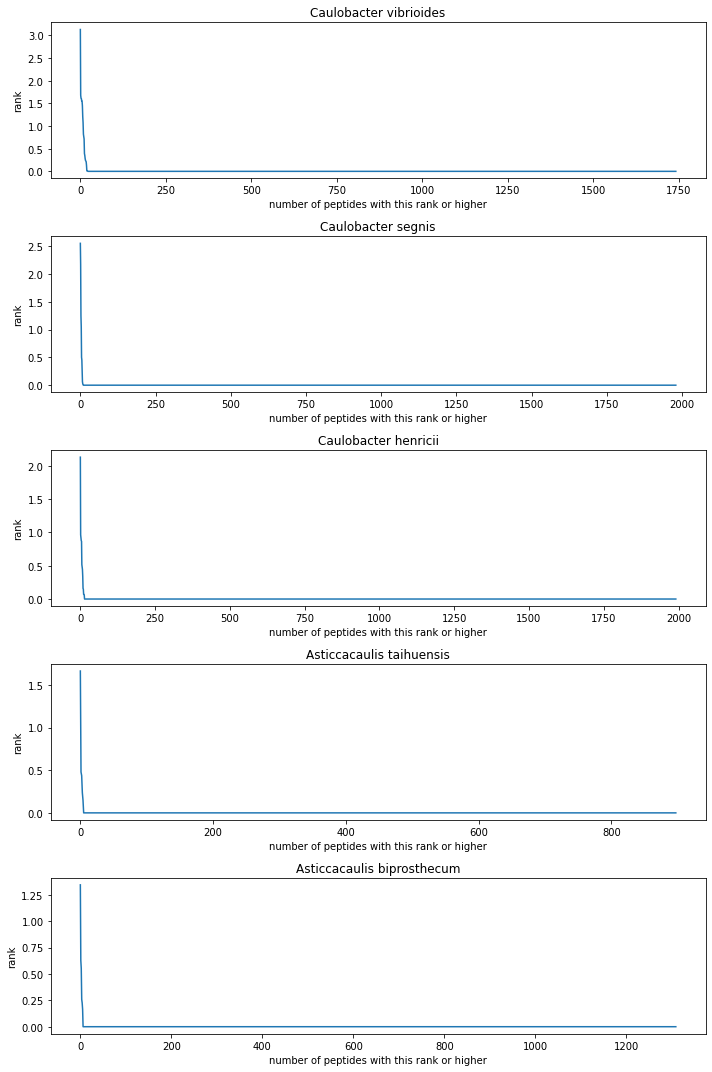

In [19]:
fig, axs = plt.subplots(len(genomeArr), 1, figsize=(10,15))

for i in range(0, len(genomeArr)):
    y = genomeDict[genomeArr[i]["genome"]]["ranks"]
    x = range(0, len(y))
    axs[i].plot(x, y)
    axs[i].set_title(genomeArr[i]["genome"])
    axs[i].set(xlabel="number of peptides with this rank or higher", ylabel="rank")

plt.tight_layout()
plt.show()